# SetUP


In [19]:
#I have removed my credencials for my privecy please add yours if you need to check

api_key = ''  
api_secret = ''

# Dataset Preparation

In [ ]:
# Import necessary libraries
from binance.client import Client
import numpy as np
from datetime import datetime, timezone
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import holidays

client = Client(api_key, api_secret, requests_params={'timeout': 20000})  # Timeout set to 20 seconds

# Define Function to Fetch Historical Data
def get_historical_data(symbol, interval, start_str, end_str=None):
    if end_str is None:
        end_str = datetime.now(timezone.utc).strftime('%d %b %Y %H:%M:%S')
    try:
        klines = client.get_historical_klines(symbol, interval, start_str, end_str)
    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()
    df = pd.DataFrame(klines, columns=['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 'Quote Asset Volume', 'Number of Trades', 'Taker Buy Base Asset Volume', 'Taker Buy Quote Asset Volume', 'Ignore'])
    df['Open Time'] = pd.to_datetime(df['Open Time'], unit='ms')
    df['Close Time'] = pd.to_datetime(df['Close Time'], unit='ms')
    for col in ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume', 'Taker Buy Base Asset Volume', 'Taker Buy Quote Asset Volume']:
        df[col] = df[col].astype(float)
    
    # Fetch Mark Price and add it as an additional feature
    mark_prices = client.futures_mark_price(symbol=symbol)
    if isinstance(mark_prices, list):  # Check if mark_prices is a list
        mark_price = mark_prices[0]['markPrice']  # Get the mark price from the first item in the list
    else:
        mark_price = mark_prices['markPrice']
    df['Mark_Price'] = float(mark_price)
    
    # Additional Features
    df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['RSI'] = calculate_rsi(df['Close'], 14)
    df['ROC'] = ((df['Close'] - df['Close'].shift(12)) / df['Close'].shift(12)) * 100
    df['OBV'] = calculate_obv(df['Close'], df['Volume'])
    df['ATR'] = calculate_atr(df['High'], df['Low'], df['Close'], 14)
    
    # Include Lagged Values of Mark Price
    df['Mark_Price_Lag1'] = df['Close'].shift(1)
    df['Mark_Price_Lag2'] = df['Close'].shift(2)
    # You can include more lagged values if needed

    # Include Time-based Features
    df['Day_of_Week'] = df['Open Time'].dt.dayofweek
    df['Hour_of_Day'] = df['Open Time'].dt.hour
    df['Is_Weekend'] = np.where(df['Day_of_Week'].isin([5, 6]), 1, 0)

    # Include Holiday Indicators
    us_holidays = holidays.US()
    df['Is_Holiday'] = df['Open Time'].dt.date.apply(lambda x: 1 if x in us_holidays else 0)

    # Drop 'Ignore' column
    df.drop(columns=['Ignore'], inplace=True)
    
    # Drop rows with missing values for additional features
    df.dropna(inplace=True)
    
    return df

# Calculate RSI
def calculate_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate OBV
def calculate_obv(close, volume):
    obv = (volume * (close.diff() > 0) * 2 - 1).cumsum()
    return obv

# Calculate ATR
def calculate_atr(high, low, close, window=14):
    tr = pd.concat([high - low, abs(high - close.shift()), abs(low - close.shift())], axis=1).max(axis=1)
    atr = tr.rolling(window=window).mean()
    return atr

# Fetch Historical Data
symbol = 'BTCUSDT'
interval = '1m'
start_str = '1 Jan 2000'
historical_data = get_historical_data(symbol, interval, start_str)

# Save to CSV
historical_data.to_csv('MarkPricebinance_data_for_model_training.csv', index=False)
print("Data saved to 'binance_data_for_model_training.csv'.")


In [1]:
import pandas as pd

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('MarkPricebinance_data_for_model_training.csv')

In [3]:
df.tail()

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,...,RSI,ROC,OBV,ATR,Mark_Price_Lag1,Mark_Price_Lag2,Day_of_Week,Hour_of_Day,Is_Weekend,Is_Holiday
3618708,2024-07-11 09:28:00,58350.00,58350.00,58302.00,58302.01,17.63662,2024-07-11 09:28:59.999,1.028686e+06,1037,13.11395,...,56.696309,0.075526,1.724908e+08,37.758571,58350.00,58364.01,3,9,0,0
3618709,2024-07-11 09:29:00,58302.00,58321.43,58300.11,58310.01,9.80861,2024-07-11 09:29:59.999,5.719546e+05,927,8.13774,...,57.154215,0.138332,1.724908e+08,38.701429,58302.01,58350.00,3,9,0,0
3618710,2024-07-11 09:30:00,58310.01,58317.87,58280.00,58280.01,16.30735,2024-07-11 09:30:59.999,9.508143e+05,829,6.59947,...,52.713771,0.137423,1.724908e+08,36.990000,58310.01,58302.01,3,9,0,0
3618711,2024-07-11 09:31:00,58280.01,58300.00,58210.98,58258.01,19.81348,2024-07-11 09:31:59.999,1.154361e+06,1606,12.09916,...,53.579578,-0.008977,1.724908e+08,41.284286,58280.01,58310.01,3,9,0,0
3618712,2024-07-11 09:32:00,58258.00,58258.01,58238.25,58250.00,18.97646,2024-07-11 09:32:59.999,1.105364e+06,1172,10.18753,...,56.620823,-0.102401,1.724908e+08,40.592143,58258.01,58280.01,3,9,0,0


In [5]:
# Convert the 'open_time' and 'Close Time' column to datetime format
df['Open Time'] = pd.to_datetime(df['Open Time'])  # Assuming 'open_time' is in milliseconds
df['Close Time'] = pd.to_datetime(df['Open Time'])
# Display the DataFrame
df.head()


,Open Time,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,...,RSI,ROC,OBV,ATR,Mark_Price_Lag1,Mark_Price_Lag2,Day_of_Week,Hour_of_Day,Is_Weekend,Is_Holiday
0,2017-08-17 04:13:00,4261.48,4261.48,4261.48,4261.48,0.000000,2017-08-17 04:13:00,0.000000,0,0.000000,...,50.0,0.000000,-13.477852,2.725714,4261.48,4261.48,3,4,0,0
1,2017-08-17 04:14:00,4261.48,4261.48,4261.48,4261.48,0.000000,2017-08-17 04:14:00,0.000000,0,0.000000,...,50.0,-0.445736,-14.477852,2.725714,4261.48,4261.48,3,4,0,0
2,2017-08-17 04:15:00,4261.48,4261.48,4261.48,4261.48,0.000000,2017-08-17 04:15:00,0.000000,0,0.000000,...,50.0,0.000000,-15.477852,2.725714,4261.48,4261.48,3,4,0,0
3,2017-08-17 04:16:00,4261.48,4261.48,4261.48,4261.48,0.000000,2017-08-17 04:16:00,0.000000,0,0.000000,...,0.0,0.000000,-16.477852,1.362857,4261.48,4261.48,3,4,0,0
4,2017-08-17 04:17:00,4261.48,4264.88,4261.48,4264.88,0.075455,2017-08-17 04:17:00,321.603336,2,0.075455,...,100.0,0.079784,-17.326942,0.242857,4261.48,4261.48,3,4,0,0


In [7]:
df.shape

(3618713, 26)

In [9]:
df.dtypes

Open Time                       datetime64[ns]
Open                                   float64
High                                   float64
Low                                    float64
Close                                  float64
Volume                                 float64
Close Time                      datetime64[ns]
Quote Asset Volume                     float64
Number of Trades                         int64
Taker Buy Base Asset Volume            float64
Taker Buy Quote Asset Volume           float64
Mark_Price                             float64
VWAP                                   float64
EMA12                                  float64
EMA26                                  float64
MACD                                   float64
RSI                                    float64
ROC                                    float64
OBV                                    float64
ATR                                    float64
Mark_Price_Lag1                        float64
Mark_Price_La

In [11]:
# Check for missing values in each column
print(df.isnull().sum())

Open Time                       0
Open                            0
High                            0
Low                             0
Close                           0
Volume                          0
Close Time                      0
Quote Asset Volume              0
Number of Trades                0
Taker Buy Base Asset Volume     0
Taker Buy Quote Asset Volume    0
Mark_Price                      0
VWAP                            0
EMA12                           0
EMA26                           0
MACD                            0
RSI                             0
ROC                             0
OBV                             0
ATR                             0
Mark_Price_Lag1                 0
Mark_Price_Lag2                 0
Day_of_Week                     0
Hour_of_Day                     0
Is_Weekend                      0
Is_Holiday                      0
dtype: int64


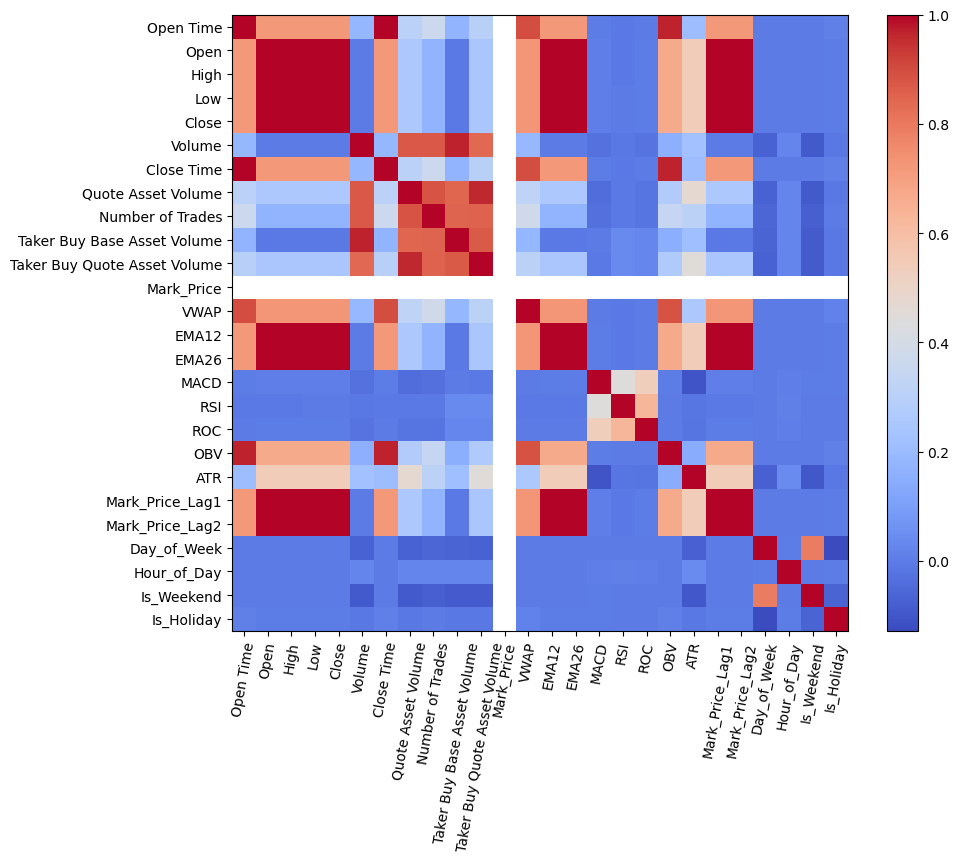

In [15]:
# Calculate correlation matrix
import matplotlib.pyplot as 
correlation = df.corr()
# Create a heatmap to visualize correlations
plt.figure(figsize=(10, 8))
plt.imshow(correlation, cmap='coolwarm')
plt.xticks(range(len(correlation.columns)), correlation.columns, rotation=80)
plt.yticks(range(len(correlation.columns)), correlation.columns)
plt.colorbar()
plt.show()
